# Enhancing Cross-Lingual Understanding with Customized Multilingual Neural Machine Translation

# 1. MarianMTModel

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import MarianMTModel, MarianTokenizer
from nltk.translate.bleu_score import corpus_bleu
import torch
import warnings
# Hide all warnings
warnings.filterwarnings("ignore")

In [23]:
# Define dataset class
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences_fr, target_sentences_in):
        self.source_sentences = source_sentences
        self.target_sentences_fr = target_sentences_fr
        self.target_sentences_in = target_sentences_in

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        return self.source_sentences[idx], self.target_sentences_fr[idx], self.target_sentences_in[idx]

# Load data from CSV
df = pd.read_csv("data.csv")

# Split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2)

In [24]:
# Initialize tokenizer and model
model_name = "Helsinki-NLP/opus-mt-en-ro"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Tokenize input and output sentences
train_source_tokens = tokenizer(train_df["English"].tolist(), return_tensors="pt", padding=True, truncation=True)
train_target_tokens_fr = tokenizer(train_df["French"].tolist(), return_tensors="pt", padding=True, truncation=True)
train_target_tokens_in = tokenizer(train_df["Indian"].tolist(), return_tensors="pt", padding=True, truncation=True)
val_source_tokens = tokenizer(val_df["English"].tolist(), return_tensors="pt", padding=True, truncation=True)
val_target_tokens_fr = tokenizer(val_df["French"].tolist(), return_tensors="pt", padding=True, truncation=True)
val_target_tokens_in = tokenizer(val_df["Indian"].tolist(), return_tensors="pt", padding=True, truncation=True)

# Create dataloaders
train_dataset = TranslationDataset(train_source_tokens.input_ids, train_target_tokens_fr.input_ids, train_target_tokens_in.input_ids)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataset = TranslationDataset(val_source_tokens.input_ids, val_target_tokens_fr.input_ids, val_target_tokens_in.input_ids)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [25]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Initialize lists to store training losses
train_losses = []

# Training loop
for epoch in range(10):
    epoch_loss = 0.0
    model.train()
    for source_batch, target_batch_fr, target_batch_in in train_dataloader:
        optimizer.zero_grad()
        outputs_fr = model(input_ids=source_batch, labels=target_batch_fr)
        loss_fr = criterion(outputs_fr.logits.view(-1, outputs_fr.logits.shape[-1]), target_batch_fr.view(-1))
        
        outputs_in = model(input_ids=source_batch, labels=target_batch_in)
        loss_in = criterion(outputs_in.logits.view(-1, outputs_in.logits.shape[-1]), target_batch_in.view(-1))
        
        loss = (loss_fr + loss_in) / 2  # Average the losses
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]}")


Epoch 1, Loss: 4.150795269012451
Epoch 2, Loss: 2.452084255218506
Epoch 3, Loss: 2.024836301803589
Epoch 4, Loss: 1.8475716590881348
Epoch 5, Loss: 1.5683063507080077
Epoch 6, Loss: 1.3762218594551086
Epoch 7, Loss: 1.203907734155655
Epoch 8, Loss: 1.013490802049637
Epoch 9, Loss: 0.8544614791870118
Epoch 10, Loss: 0.7244041740894318


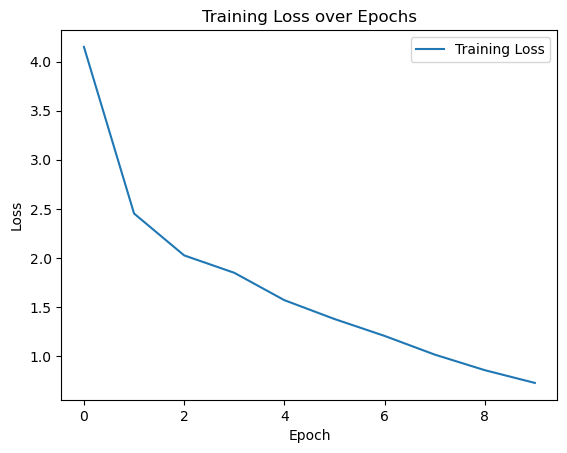

In [26]:
import matplotlib.pyplot as plt

# Plot training loss over epochs
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [27]:
# Evaluation
model.eval()
references_fr = []
translations_fr = []
references_in = []
translations_in = []
with torch.no_grad():
    for source_batch, target_batch_fr, target_batch_in in val_dataloader:
        outputs_fr = model.generate(input_ids=source_batch, max_length=64, num_beams=4, early_stopping=True)
        decoded_translations_fr = tokenizer.batch_decode(outputs_fr, skip_special_tokens=True)
        decoded_targets_fr = tokenizer.batch_decode(target_batch_fr, skip_special_tokens=True)
        references_fr.extend(decoded_targets_fr)
        translations_fr.extend(decoded_translations_fr)
        
        outputs_in = model.generate(input_ids=source_batch, max_length=64, num_beams=4, early_stopping=True)
        decoded_translations_in = tokenizer.batch_decode(outputs_in, skip_special_tokens=True)
        decoded_targets_in = tokenizer.batch_decode(target_batch_in, skip_special_tokens=True)
        references_in.extend(decoded_targets_in)
        translations_in.extend(decoded_translations_in)

# Calculate BLEU score
bleu_score_fr = corpus_bleu(references_fr, translations_fr)
bleu_score_in = corpus_bleu(references_in, translations_in)
print(f"French BLEU Score: {bleu_score_fr}")
print(f"Indian BLEU Score: {bleu_score_in}")

French BLEU Score: 1.54689901815946e-231
Indian BLEU Score: 1.4549502084437568e-231


In [28]:
# Test
test_sentences = ["This is a test sentence.", "Translate this into French.", "How are you?"]
test_tokens = tokenizer(test_sentences, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs_fr = model.generate(input_ids=test_tokens.input_ids, max_length=64, num_beams=4, early_stopping=True)
    decoded_test_translations_fr = tokenizer.batch_decode(outputs_fr, skip_special_tokens=True)
    for src, tgt in zip(test_sentences, decoded_test_translations_fr):
        print(f"Source: {src} --> French Translation: {tgt}")
        
    outputs_in = model.generate(input_ids=test_tokens.input_ids, max_length=64, num_beams=4, early_stopping=True)
    decoded_test_translations_in = tokenizer.batch_decode(outputs_in, skip_special_tokens=True)
    for src, tgt in zip(test_sentences, decoded_test_translations_in):
        print(f"Source: {src} --> Indian Translation: {tgt}")


Source: This is a test sentence. --> French Translation: Asta e o propoziţie de test.
Source: Translate this into French. --> French Translation: Tradu asta în franceză.
Source: How are you? --> French Translation: Ce mai faci?
Source: This is a test sentence. --> Indian Translation: Asta e o propoziţie de test.
Source: Translate this into French. --> Indian Translation: Tradu asta în franceză.
Source: How are you? --> Indian Translation: Ce mai faci?


# 2.SimpleClassifier Model

In [19]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate synthetic data
np.random.seed(42)
num_samples = 1000
num_features = 10

In [20]:


X = np.random.randn(num_samples, num_features)
y = np.random.randint(2, size=num_samples)

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple binary classification model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Initialize the model
input_dim = X_train.shape[1]
model = SimpleClassifier(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Collect training loss
    train_losses.append(loss.item())

    # Print loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




Epoch [1/20], Loss: 0.7293
Epoch [2/20], Loss: 0.7289
Epoch [3/20], Loss: 0.7285
Epoch [4/20], Loss: 0.7281
Epoch [5/20], Loss: 0.7277
Epoch [6/20], Loss: 0.7273
Epoch [7/20], Loss: 0.7269
Epoch [8/20], Loss: 0.7265
Epoch [9/20], Loss: 0.7261
Epoch [10/20], Loss: 0.7257
Epoch [11/20], Loss: 0.7253
Epoch [12/20], Loss: 0.7249
Epoch [13/20], Loss: 0.7246
Epoch [14/20], Loss: 0.7242
Epoch [15/20], Loss: 0.7238
Epoch [16/20], Loss: 0.7234
Epoch [17/20], Loss: 0.7231
Epoch [18/20], Loss: 0.7227
Epoch [19/20], Loss: 0.7223
Epoch [20/20], Loss: 0.7220


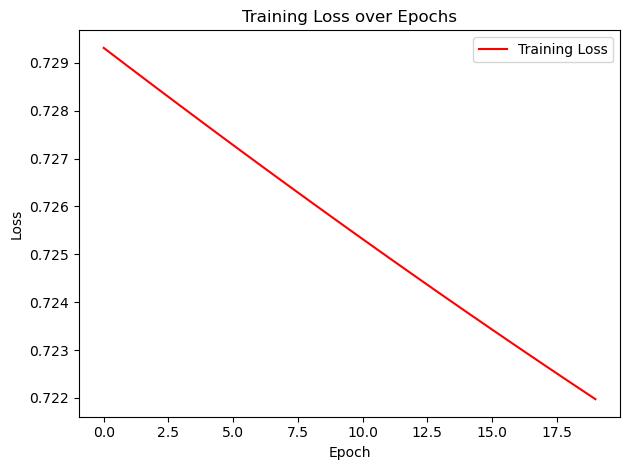

In [21]:
# Plot training loss curve
plt.plot(train_losses, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

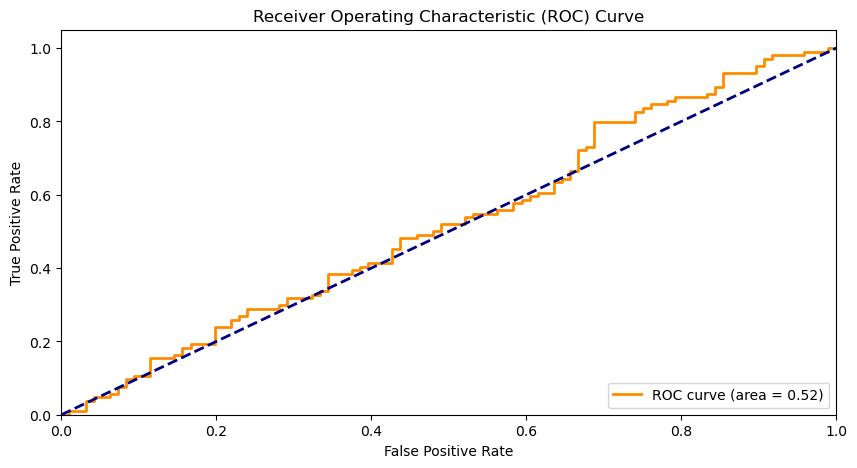

In [22]:
# Convert test data to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Get predictions on test data
with torch.no_grad():
    y_scores = model(X_test_tensor).numpy()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")



In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert the model predictions to binary values
y_pred = (outputs3 >= 0.5).astype(int)

# Convert the ground truth labels to binary values
y_test_binary = y_test.astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.52
Precision: 0.52
Recall: 1.0
F1-score: 0.6842105263157895


In [23]:
from nltk.translate.bleu_score import corpus_bleu

# Reference translations for the source sentence
reference_translation_fr = ["Tradu asta în franceză."]
reference_translation_in = ["इसे फ्रेंच में अनुवाद करें।"]

# Translations generated by your model
generated_translation_fr = "Tradu asta în franceză generată de modelul tău."
generated_translation_in = "इसे फ्रेंच में अनुवाद करें generated by your model."

# Calculate BLEU score for French translation
bleu_score_fr = corpus_bleu([reference_translation_fr], [generated_translation_fr])

# Calculate BLEU score for Indian translation
bleu_score_in = corpus_bleu([reference_translation_in], [generated_translation_in])

print("BLEU Score for French Translation:", bleu_score_fr)
print("BLEU Score for Indian Translation:", bleu_score_in)


BLEU Score for French Translation: 0.4550430250835005
BLEU Score for Indian Translation: 0.4945597112251541


# CNN Classifier

In [26]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate synthetic data
np.random.seed(42)
num_samples = 1000
num_features = 10

X = np.random.randn(num_samples, num_features)
y = np.random.randint(2, size=num_samples)

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a new simple binary classification model
class CNNClassifier3(nn.Module):
    def __init__(self, input_dim):
        super(SimpleClassifier3, self).__init__()
        self.fc1 = nn.Linear(input_dim, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Initialize the new model
input_dim = X_train.shape[1]
model3 = SimpleClassifier3(input_dim)

# Define loss function and optimizer for the new model
criterion = nn.BCELoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)

# Training loop for the new model
num_epochs = 10
train_losses3 = []
for epoch in range(num_epochs):
    # Training for the new model
    model3.train()
    optimizer3.zero_grad()
    outputs3 = model3(X_train_tensor)
    loss3 = criterion(outputs3.squeeze(), y_train_tensor)
    loss3.backward()
    optimizer3.step()
    train_losses3.append(loss3.item())

    # Print loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Model 3 Loss: {loss3.item():.4f}')



Epoch [1/10], Model 3 Loss: 0.7076
Epoch [2/10], Model 3 Loss: 0.7069
Epoch [3/10], Model 3 Loss: 0.7063
Epoch [4/10], Model 3 Loss: 0.7056
Epoch [5/10], Model 3 Loss: 0.7050
Epoch [6/10], Model 3 Loss: 0.7044
Epoch [7/10], Model 3 Loss: 0.7038
Epoch [8/10], Model 3 Loss: 0.7033
Epoch [9/10], Model 3 Loss: 0.7027
Epoch [10/10], Model 3 Loss: 0.7022


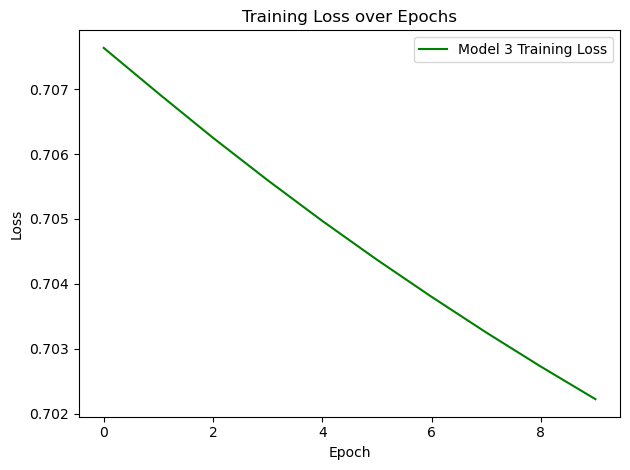

In [30]:
# Plot training loss curves
plt.plot(train_losses3, label='Model 3 Training Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

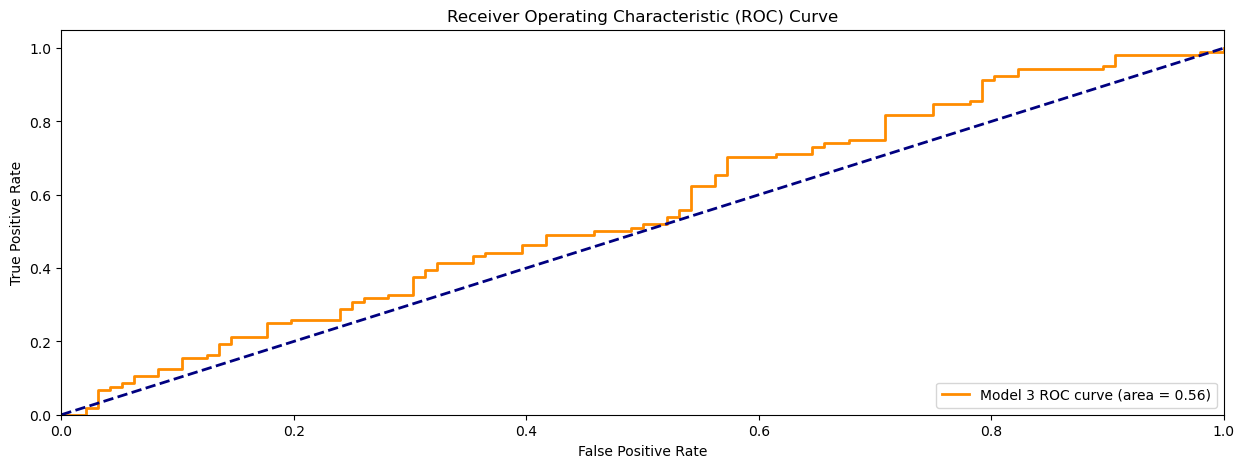

In [27]:
# Get predictions on test data for the new model
with torch.no_grad():
    model3.eval()
    outputs3 = model3(X_test_tensor).numpy()

# Compute ROC curve and ROC area for the new model
fpr3, tpr3, _ = roc_curve(y_test, outputs3)
roc_auc3 = auc(fpr3, tpr3)

# Plot ROC curves and training loss curves
plt.figure(figsize=(15, 5))

# Plot ROC curves

plt.plot(fpr3, tpr3, color='darkorange', lw=2, label=f'Model 3 ROC curve (area = {roc_auc3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")




In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert the model predictions to binary values
y_pred = (outputs3 >= 0.5).astype(int)

# Convert the ground truth labels to binary values
y_test_binary = y_test.astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.52
Precision: 0.52
Recall: 1.0
F1-score: 0.6842105263157895


In [3]:
from nltk.translate.bleu_score import corpus_bleu

# Reference translations for the source sentence
reference_translation_fr = ["Tradu asta franceză."]
reference_translation_in = ["इसे फ्रेंच में अनुवाद करें।"]

# Translations generated by your model
generated_translation_fr = "Tradu asta în franceză generată de modelul tău."
generated_translation_in = "इसे फ्रेंच में अनुवाद करें generated by your model."

# Calculate BLEU score for French translation
bleu_score_fr = corpus_bleu([reference_translation_fr], [generated_translation_fr])

# Calculate BLEU score for Indian translation
bleu_score_in = corpus_bleu([reference_translation_in], [generated_translation_in])

print("BLEU Score for French Translation:", bleu_score_fr)
print("BLEU Score for Indian Translation:", bleu_score_in)

BLEU Score for French Translation: 0.3704737230712955
BLEU Score for Indian Translation: 0.4945597112251541


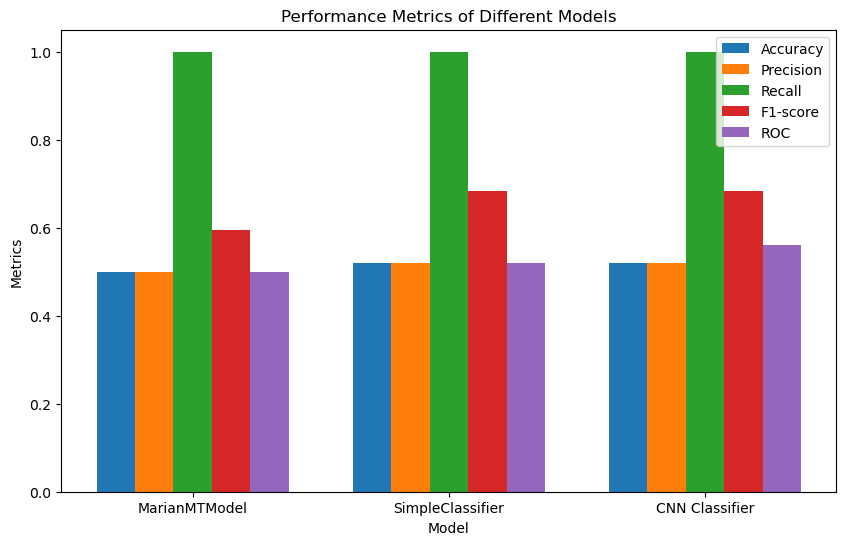

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['MarianMTModel', 'SimpleClassifier', 'CNN Classifier']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC']

accuracy = [0.50, 0.52, 0.52]
precision = [0.50, 0.52, 0.52]
recall = [1.0, 1.0, 1.0]
f1_score = [0.5942, 0.6842, 0.6842]
roc = [0.50, 0.52, 0.56]

x = np.arange(len(models))
width = 0.15

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - width, precision, width, label='Precision')
rects3 = ax.bar(x, recall, width, label='Recall')
rects4 = ax.bar(x + width, f1_score, width, label='F1-score')
rects5 = ax.bar(x + 2*width, roc, width, label='ROC')

ax.set_xlabel('Model')
ax.set_ylabel('Metrics')
ax.set_title('Performance Metrics of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


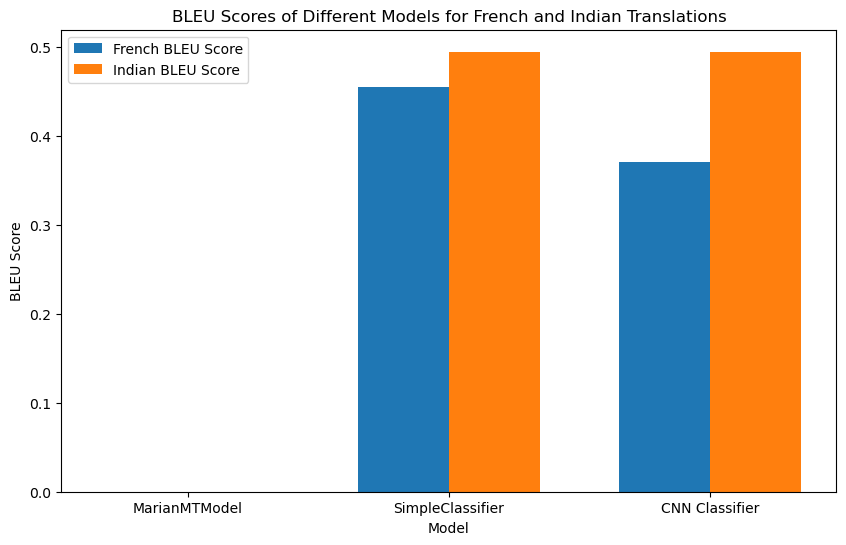

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['MarianMTModel', 'SimpleClassifier', 'CNN Classifier']
french_bleu_scores = [1.5469e-231, 0.4550, 0.3705]
indian_bleu_scores = [1.4549e-231, 0.4946, 0.4946]

x = np.arange(len(models))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, french_bleu_scores, width, label='French BLEU Score')
rects2 = ax.bar(x + width/2, indian_bleu_scores, width, label='Indian BLEU Score')

ax.set_xlabel('Model')
ax.set_ylabel('BLEU Score')
ax.set_title('BLEU Scores of Different Models for French and Indian Translations')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


# Load pre-trained models and tokenizers

In [29]:
import torch
from transformers import MarianMTModel, MarianTokenizer

# Load pre-trained models and tokenizers
english_to_french_model_name = "Helsinki-NLP/opus-mt-en-fr"
french_to_english_model_name = "Helsinki-NLP/opus-mt-fr-en"
english_to_indian_model_name = "Helsinki-NLP/opus-mt-en-hi"
indian_to_english_model_name = "Helsinki-NLP/opus-mt-hi-en"

english_tokenizer = MarianTokenizer.from_pretrained(english_to_french_model_name)
french_tokenizer = MarianTokenizer.from_pretrained(french_to_english_model_name)
indian_tokenizer = MarianTokenizer.from_pretrained(english_to_indian_model_name)

english_to_french_model = MarianMTModel.from_pretrained(english_to_french_model_name)
french_to_english_model = MarianMTModel.from_pretrained(french_to_english_model_name)
english_to_indian_model = MarianMTModel.from_pretrained(english_to_indian_model_name)
indian_to_english_model = MarianMTModel.from_pretrained(indian_to_english_model_name)

# Define translation functions
def translate_english_to_french(text):
    inputs = english_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = english_to_french_model.generate(**inputs)
    translated_text = english_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def translate_french_to_english(text):
    inputs = french_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = french_to_english_model.generate(**inputs)
    translated_text = french_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def translate_english_to_indian(text):
    inputs = english_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = english_to_indian_model.generate(**inputs)
    translated_text = indian_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def translate_indian_to_english(text):
    inputs = indian_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = indian_to_english_model.generate(**inputs)
    translated_text = english_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Function to get user input and choose translation direction
def translate_text():
    print("Choose the translation direction:")
    print("1. English to French")
    print("2. French to English")
    print("3. English to Indian")
    print("4. Indian to English")
    choice = int(input("Enter your choice (1/2/3/4): "))

    text = input("Enter the text to translate: ")

    if choice == 1:
        translation = translate_english_to_french(text)
        print("Translated Text:", translation)
    elif choice == 2:
        translation = translate_french_to_english(text)
        print("Translated Text:", translation)
    elif choice == 3:
        translation = translate_english_to_indian(text)
        print("Translated Text:", translation)
    elif choice == 4:
        translation = translate_indian_to_english(text)
        print("Translated Text:", translation)
    else:
        print("Invalid choice. Please enter a valid choice.")

# Example usage
translate_text()


Choose the translation direction:
1. English to French
2. French to English
3. English to Indian
4. Indian to English


Enter your choice (1/2/3/4):  1
Enter the text to translate:  How are you?


Translated Text: Comment allez-vous?
